# Importing Libraries

In [1]:
import os
import gc
import cv2
import json
import time
import shutil
import numpy as np
from tqdm import tqdm
import mediapipe as mp
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from concurrent.futures import ThreadPoolExecutor
from IPython.display import clear_output, FileLink
import keras
from PIL import Image, ImageOps
import pandas as pd
from keras import layers

In [2]:
from sklearn.model_selection import StratifiedShuffleSplit

In [119]:
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay

In [3]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

In [3]:
WORK_DIR = "../"
RESOURCES_DIR = WORK_DIR + "resources/"
DATA_DIR = WORK_DIR + "data/auslan_words_video/"
VIDEOS_DIR = WORK_DIR + "data/auslan_words_video/videos/"
TF_MODEL_DIR = WORK_DIR + "models/auslan_words_classifier/"
MODEL_DIR = WORK_DIR + "models/"

In [5]:
os.makedirs(TF_MODEL_DIR, exist_ok=True)

---

# Dataset Preparation
## (Done Once)

In [6]:
raw_df = pd.read_excel(WORK_DIR + "Isolated_Sign_Language_Recognition.xlsx", index_col=0)
raw_df.head()

,Gloss,Split,Video_ID
0,feeder,train,1
1,feeder,train,2
2,feeder,train,3
3,feeder,dev,4
4,feeder,test,5


In [7]:
gloss = raw_df.value_counts('Gloss')
gloss.to_dict()

labels = []
for k,v in gloss.items():
    if 15 <= v <= 50:
        labels.append(k)

print(f'Number of words to train: {len(labels)}')
print(labels)

Number of words to train: 10
['egg', 'use', 'do', 'jay', 'tools', 'tool', 'pattern', 'wool', 'map', 'wood']


In [8]:
df = raw_df[raw_df['Gloss'].isin(labels)]
df


,Gloss,Split,Video_ID
28,use,train,29
29,use,train,30
30,use,train,31
31,use,train,32
32,use,train,33
...,...,...,...
2823,do,train,2824
2824,do,train,2825
2825,do,train,2826
2826,do,dev,2827


In [9]:
df.to_csv(WORK_DIR + 'auslan_words_ds.csv', index=False)

---

In [10]:
df = pd.read_csv(WORK_DIR + 'auslan_words_ds.csv', index_col=False)

---

# Videos Standardization

In [11]:
IMAGE_SIZE = 224
PADDING_COLOUR = [0, 255, 0]
CROP_MARGIN = 20

In [12]:
def resize_image(image, height=IMAGE_SIZE, width=IMAGE_SIZE):
    image = Image.fromarray(image)
    image.thumbnail((width, height))
    image = np.asarray(image)
    y_border = max(height - image.shape[0], 0)
    x_border = max(width - image.shape[1], 0)
    top = y_border
    bottom = 0
    left = x_border
    right = 0
    image = cv2.copyMakeBorder(
        image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=PADDING_COLOUR
    )
    return image

In [13]:
hands = mp.solutions.hands.Hands()


def get_2hands_coord(image_rgb):
    result = hands.process(image_rgb)
    height, width, _ = image_rgb.shape
    # Check if hands are detected

    left_x = width
    right_x = 0
    bottom_y = height
    top_y = 0


    if result.multi_hand_landmarks:
        x_coordinates = []
        y_coordinates = []

        if len(result.multi_hand_landmarks) < 2:
            print("Cannot detect two hands to crop the picture")
            return (left_x, right_x, top_y, bottom_y)  
        else:
            print("Detect two hands")
        
        for hand_landmarks in result.multi_hand_landmarks:
            # Draw landmarks on the frame
            mp.solutions.drawing_utils.draw_landmarks(image_rgb, hand_landmarks, mp.solutions.hands.HAND_CONNECTIONS)

            # Get the top left corner of the detected hand's bounding box.

            for landmark in hand_landmarks.landmark:
                x_coordinates.append(landmark.x)
                y_coordinates.append(landmark.y)

        left_x = int(min(x_coordinates) * width)
        right_x = int(max(x_coordinates) * width)
        bottom_y = int(min(y_coordinates) * height)
        top_y = int(max(y_coordinates) * height)

        plt.imshow(image_rgb)
        plt.show()
    else:
        print("No hands detected")

    return (left_x, right_x, top_y, bottom_y)

I0000 00:00:1728450321.532932 6502813 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M3 Pro


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1728450321.555459 6816828 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1728450321.560134 6816836 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


In [14]:
def get_video_hands_coord(video_path):
    cap = cv2.VideoCapture(video_path)

    start_frame = 1
    end_frame = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    # print(end_frame)

    # num_landmarks = HAND_NUM * 2 + POSE_NUM + FACE_NUM
    # all_frame_landmarks = np.zeros((end_frame - start_frame + 1, num_landmarks, 3))
    frame_index = 1
    list_left_x = []
    list_right_x = []
    list_top_y = []
    list_bottom_y = []

    while cap.isOpened() and frame_index <= end_frame:
        ret, frame = cap.read()
        if not ret:
            break
        if frame_index >= start_frame:
            # frame.flags.writeable = False
            # frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            (left_x, right_x, top_y, bottom_y) = get_2hands_coord(frame)

            list_left_x.append(left_x)
            list_right_x.append(right_x)
            list_top_y.append(top_y)
            list_bottom_y.append(bottom_y)

        frame_index += 1

    cap.release()
    hands.reset()

    return (min(list_left_x), max(list_right_x), max(list_top_y), min(list_bottom_y))

In [15]:
def crop_image(image, left_x, right_x, top_y, bottom_y):
    orig_height, orig_width, _ = image.shape

    if left_x > right_x:
        tmp = left_x
        left_x = right_x
        right_x = tmp
    if bottom_y > top_y:
        tmp = top_y
        top_y = bottom_y
        bottom_y = tmp

    left_x = max(left_x - CROP_MARGIN, 0)
    right_x = min(right_x + CROP_MARGIN, orig_width)
    bottom_y = max(bottom_y - CROP_MARGIN, 0)
    top_y = min(top_y + CROP_MARGIN, orig_height)

    cropped_image = image[bottom_y:top_y, left_x:right_x]

    cropped_image = cv2.cvtColor(cropped_image, cv2.COLOR_RGB2BGR)

    return cropped_image

In [16]:
def load_video(video_path, detect_hands = True):
    cap = cv2.VideoCapture(video_path)
    frames = []

    start_frame = 1
    end_frame = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    if detect_hands == True:
        (left_x, right_x, top_y, bottom_y) = get_video_hands_coord(video_path)

    frame_index = 1
    while cap.isOpened() and frame_index <= end_frame:
        ret, frame = cap.read()
        if not ret:
            break
        if frame_index >= start_frame:

            if detect_hands != True:
                orig_height, orig_width, _ = frame.shape
                left_x = int(0.2 * orig_width)
                right_x = int(0.8 * orig_width)
                top_y = int(0.75 * orig_height)
                bottom_y = int(0 * orig_height)
                
            frame = crop_image(frame, left_x, right_x, top_y, bottom_y)
            # frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            
            frame = resize_image(frame)

            # frame = frame[:, :, [2, 1, 0]]

            frames.append(frame)

            frame_index += 1
    cap.release()

    return np.array(frames)

In [37]:
frames = load_video(VIDEOS_DIR + '1702.mp4', detect_hands=False)

In [38]:
for frame in frames:
    plt.imshow(frame)
    plt.show()

---

<div id="Features_Extraction">

# **Features Extraction**

In [17]:
def build_feature_extractor():
    feature_extractor = keras.applications.InceptionV3(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
    )
    preprocess_input = keras.applications.inception_v3.preprocess_input

    inputs = keras.Input((IMAGE_SIZE, IMAGE_SIZE, 3))
    preprocessed = preprocess_input(inputs)

    outputs = feature_extractor(preprocessed)
    return keras.Model(inputs, outputs, name="feature_extractor")


feature_extractor = build_feature_extractor()

---

<div id="Data_Loading">
    
# **Data Loading**

In [38]:
MAX_SEQ_LENGTH = 10
NUM_FEATURES = 2048

In [19]:
trainval_df = df[df['Split'].isin(['train', 'dev'])]
test_df = df[df['Split'] == 'test']

In [82]:
def prepare_all_videos(df):
    num_samples = len(df)
    idx = 0
    print(f'Number of samples: {num_samples}')

    # `frame_masks` and `frame_features` are what we will feed to our sequence model.
    # `frame_masks` will contain a bunch of booleans denotin g if a timestep is
    # masked with padding or not.
    frame_masks = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH), dtype="bool")
    frame_features = np.zeros(
        shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
    )
    video_labels = []

    for _, row in df.iterrows():
        print(f"Processing index {idx} with video ID {row['Video_ID']}")
        video_labels.append(row['Gloss'])
        video_id = row['Video_ID']
        video_path = os.path.join(VIDEOS_DIR, f"{video_id}.mp4")

        frames = load_video(video_path, detect_hands=False)
        if len(frames) == 0:
            continue

        if len(frames) > MAX_SEQ_LENGTH:
            cropped_frames = len(frames) - MAX_SEQ_LENGTH
            frames = frames[
                (cropped_frames // 2) : (cropped_frames // 2 + MAX_SEQ_LENGTH)
            ]
        # Pad shorter videos.
        # elif len(frames) < MAX_SEQ_LENGTH:
        #     diff = MAX_SEQ_LENGTH - len(frames)
        #     padding = np.zeros((diff, IMAGE_SIZE, IMAGE_SIZE, 3))
        #     frames = np.concatenate((frames, padding))
        

        # frames = frames[None, ...]

        #Initialize placeholders to store the masks and features of the current video.
        temp_frame_mask = np.zeros(
            shape=(
                1,
                MAX_SEQ_LENGTH,
            ),
            dtype="bool",
        )
        temp_frame_features = np.zeros(
            shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
        )

        length = len(frames)
        for i, frame in enumerate(frames):
            temp_frame_features[0, i, :] = feature_extractor.predict(
                frame[None, ...],
                verbose=0,
            )
        temp_frame_mask[0, :length] = 1  # 1 = not masked, 0 = masked

        # Extract features from the frames of the current video.
        # for i, batch in enumerate(frames):
        #     video_length = batch.shape[0]
        #     length = min(MAX_SEQ_LENGTH, video_length)
        #     for j in range(length):
        #         if np.mean(batch[j, :]) > 0.0:
        #             temp_frame_features[i, j, :] = feature_extractor.predict(
        #                 batch[None, j, :]
        #             )

        #         else:
        #             temp_frame_features[i, j, :] = 0.0

        frame_features[idx,] = temp_frame_features.squeeze()
        frame_masks[idx,] = temp_frame_mask.squeeze()
        idx += 1
        # break

    return (frame_features, frame_masks), video_labels
    # return frame_features, video_labels

In [190]:
def prepare_all_videos_for_transformer(df):
    num_samples = len(df)
    idx = 0
    print(f'Number of samples: {num_samples}')

    # `frame_masks` and `frame_features` are what we will feed to our sequence model.
    # `frame_masks` will contain a bunch of booleans denotin g if a timestep is
    # masked with padding or not.
    frame_features = np.zeros(
        shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
    )
    video_labels = []

    for _, row in df.iterrows():
        print(f"Processing index {idx} with video ID {row['Video_ID']}")
        video_labels.append(row['Gloss'])
        video_id = row['Video_ID']
        video_path = os.path.join(VIDEOS_DIR, f"{video_id}.mp4")

        frames = load_video(video_path, detect_hands=False)
        if len(frames) == 0:
            continue

        if len(frames) > MAX_SEQ_LENGTH:
            cropped_frames = len(frames) - MAX_SEQ_LENGTH
            frames = frames[
                (cropped_frames // 2) : (cropped_frames // 2 + MAX_SEQ_LENGTH)
            ]
        # Pad shorter videos.
        elif len(frames) < MAX_SEQ_LENGTH:
            diff = MAX_SEQ_LENGTH - len(frames)
            padding = np.zeros((diff, IMAGE_SIZE, IMAGE_SIZE, 3))
            frames = np.concatenate((frames, padding))
        

        frames = frames[None, ...]

        #Initialize placeholders to store the masks and features of the current video.
        temp_frame_features = np.zeros(
            shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
        )

        # Extract features from the frames of the current video.
        for i, batch in enumerate(frames):
            video_length = batch.shape[0]
            length = min(MAX_SEQ_LENGTH, video_length)
            for j in range(length):
                if np.mean(batch[j, :]) > 0.0:
                    temp_frame_features[i, j, :] = feature_extractor.predict(
                        batch[None, j, :]
                    )

                else:
                    temp_frame_features[i, j, :] = 0.0

        frame_features[idx,] = temp_frame_features.squeeze()
        idx += 1

    return frame_features, video_labels

In [83]:
X_trainval, y_trainval = prepare_all_videos(trainval_df)

print(f"Frame features in trainval set: {X_trainval[0].shape}")
print(f"Frame masks in trainval set: {X_trainval[1].shape}")

Number of samples: 204
Processing index 0 with video ID 29
Processing index 1 with video ID 30
Processing index 2 with video ID 31
Processing index 3 with video ID 32
Processing index 4 with video ID 33
Processing index 5 with video ID 34
Processing index 6 with video ID 35
Processing index 7 with video ID 36
Processing index 8 with video ID 37
Processing index 9 with video ID 38
Processing index 10 with video ID 39
Processing index 11 with video ID 40
Processing index 12 with video ID 41
Processing index 13 with video ID 42
Processing index 14 with video ID 43
Processing index 15 with video ID 44
Processing index 16 with video ID 45
Processing index 17 with video ID 46
Processing index 18 with video ID 47
Processing index 19 with video ID 48
Processing index 20 with video ID 49
Processing index 21 with video ID 50
Processing index 22 with video ID 51
Processing index 23 with video ID 52
Processing index 24 with video ID 53
Processing index 25 with video ID 54
Processing index 26 with 

In [84]:
X_test, y_test = prepare_all_videos(test_df)

print(f"Frame features in test set: {X_test[0].shape}")
print(f"Frame masks in test set: {X_test[1].shape}")

Number of samples: 10
Processing index 0 with video ID 56
Processing index 1 with video ID 184
Processing index 2 with video ID 293
Processing index 3 with video ID 900
Processing index 4 with video ID 1090
Processing index 5 with video ID 1631
Processing index 6 with video ID 1704
Processing index 7 with video ID 2458
Processing index 8 with video ID 2505
Processing index 9 with video ID 2828
Frame features in test set: (10, 10, 2048)
Frame masks in test set: (10, 10)


---

<div id="Label_Encoding">
    
# **Label Encoding**

In [77]:
gloss = df.value_counts('Gloss')
gloss.to_dict()

labels = []
for k,v in gloss.items():
    if 10 <= v <= 50:
        labels.append(k)

print(f'Number of words to train: {len(labels)}')
print(labels)

Number of words to train: 10
['egg', 'use', 'do', 'jay', 'tools', 'pattern', 'tool', 'map', 'wool', 'wood']


In [78]:
label_processor = keras.layers.StringLookup(
    num_oov_indices=0, vocabulary=np.unique(labels)
)
print(label_processor.get_vocabulary())

['do', 'egg', 'jay', 'map', 'pattern', 'tool', 'tools', 'use', 'wood', 'wool']


In [85]:
y_trainval = keras.ops.convert_to_numpy(label_processor(list(y_trainval)))
y_test = keras.ops.convert_to_numpy(label_processor(list(y_test)))

In [86]:
y_trainval.shape

(204,)

---

In [158]:
BATCH_SIZE = 5
EPOCHS = 100

---

# Train set and Validation set split

In [87]:
splitter_train_val = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=84)

for train_index, val_index in splitter_train_val.split(X_trainval[0], y_trainval):
    X_train_features, X_val_features = X_trainval[0][train_index], X_trainval[0][val_index]
    X_train_mask, X_val_mask = X_trainval[1][train_index], X_trainval[1][val_index]
    y_train, y_val = y_trainval[train_index], y_trainval[val_index]

In [88]:
X_train = (X_train_features, X_train_mask)
X_val = (X_val_features, X_val_mask)

In [89]:
print(f"Frame features in train set: {X_train[0].shape}")
print(f"Frame masks in train set: {X_train[1].shape}")
print(f"Frame features in val set: {X_val[0].shape}")
print(f"Frame masks in val set: {X_val[1].shape}")

Frame features in train set: (142, 10, 2048)
Frame masks in train set: (142, 10)
Frame features in val set: (62, 10, 2048)
Frame masks in val set: (62, 10)


---

<div id="Model_Building">
    
# **Model Building**

In [180]:
def get_sequence_model_0():

    frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))
    mask_input = keras.Input((MAX_SEQ_LENGTH,), dtype="bool")

    # Refer to the following tutorial to understand the significance of using `mask`:
    # https://keras.io/api/layers/recurrent_layers/gru/
    x = keras.layers.GRU(400, return_sequences=True)(
        frame_features_input, mask=mask_input
    )
    x = keras.layers.GRU(200)(x)
    x = keras.layers.Dropout(0.4)(x)
    # x = keras.layers.Dense(100, activation="relu")(x)
    x = keras.layers.Dense(50, activation="relu")(x)
    output = keras.layers.Dense(
        len(label_processor.get_vocabulary()), activation="softmax"
    )(x)

    rnn_model = keras.Model([frame_features_input, mask_input], output)

    adam = tf.keras.optimizers.Adam(
        learning_rate=0.00001,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-06,
        amsgrad=False,
        name="Adam",
    )

    rnn_model.compile(
        loss="sparse_categorical_crossentropy", optimizer=adam, metrics=["accuracy"]
    )
    return rnn_model

In [114]:
def get_sequence_model_2():

    frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))
    mask_input = keras.Input((MAX_SEQ_LENGTH,), dtype="bool")

    # Refer to the following tutorial to understand the significance of using `mask`:
    # https://keras.io/api/layers/recurrent_layers/gru/
    x = keras.layers.LSTM(100, return_sequences=True)(
        frame_features_input, mask=mask_input
    )
    # x = keras.layers.LSTM(200, return_sequences=True)(x)
    x = keras.layers.LSTM(100)(x)
    x = keras.layers.Dropout(0.3)(x)
    x = keras.layers.Dense(100, activation="relu")(x)
    x = keras.layers.Dropout(0.3)(x)
    x = keras.layers.Dense(50, activation="relu")(x)
    output = keras.layers.Dense(
        len(label_processor.get_vocabulary()), activation="softmax"
    )(x)

    rnn_model = keras.Model([frame_features_input, mask_input], output)

    adam = tf.keras.optimizers.Adam(
        learning_rate=2e-5,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-06,
        amsgrad=False,
        name="Adam",
    )

    rnn_model.compile(
        loss="sparse_categorical_crossentropy", optimizer=adam, metrics=["accuracy"]
    )
    return rnn_model

In [161]:
# Utility for running experiments.
def run_experiment(
    model,
    train_data,
    train_label,
    val_data,
    val_label,
    test_data,
    test_label,
    model_save_name,
):
    filepath = MODEL_DIR + model_save_name
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, save_weights_only=True, save_best_only=True, verbose=1
    )

    history = model.fit(
        [train_data[0], train_data[1]],
        train_label,
        validation_data=([val_data[0], val_data[1]], val_label),
        epochs=EPOCHS,
        callbacks=[
            checkpoint,
            keras.callbacks.EarlyStopping(
                monitor="val_loss", patience=10, restore_best_weights=True
            ),
        ],
    )

    model.load_weights(filepath)
    _, accuracy = model.evaluate([test_data[0], test_data[1]], test_label)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return history

In [181]:
model = get_sequence_model_0()
model.summary()

Model: "functional_37"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_58      │ (None, 10, 2048)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_59      │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_28 (GRU)        │ (None, 10, 400)   │  2,940,000 │ input_layer_58[0… │
│                     │                   │            │ input_layer_59[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_29 (GRU)        │ (None, 200)       │    361,200 │ gru_28[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_38          │ (None, 200)       │          0 │ gru_29[0][0]      │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_88 (Dense)    │ (None, 50)        │     10,050 │ dropout_38[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_89 (Dense)    │ (None, 10)        │        510 │ dense_88[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,311,760 (12.63 MB)

 Trainable params: 3,311,760 (12.63 MB)

 Non-trainable params: 0 (0.00 B)

In [182]:
hist = run_experiment(
    model,
    X_train,
    y_train,
    X_val,
    y_val,
    X_test,
    y_test,
    "auslan_word_gru0_241009_1657.weights.h5",
)

Epoch 1/100
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.1022 - loss: 2.4879
Epoch 1: val_loss improved from inf to 2.37063, saving model to ../models/auslan_word_gru0_241009_1657.weights.h5
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 0.1034 - loss: 2.4884 - val_accuracy: 0.1129 - val_loss: 2.3706
Epoch 2/100
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.0892 - loss: 2.3865
Epoch 2: val_loss improved from 2.37063 to 2.32607, saving model to ../models/auslan_word_gru0_241009_1657.weights.h5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.0876 - loss: 2.4051 - val_accuracy: 0.1129 - val_loss: 2.3261
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.1323 - loss: 2.4375
Epoch 3: val_loss improved from 2.32607 to 2.29280, saving model to ../models/auslan_word_gru0_241009_1657.weights.h5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.1302 - loss: 2.4335 - val_accuracy: 0.1129 - val_loss: 2.2928
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accu

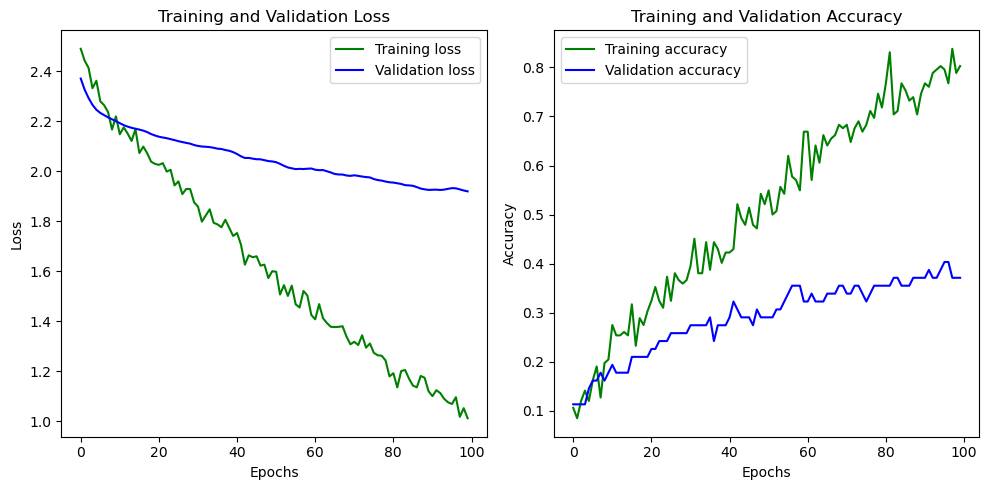

In [183]:
train_loss = hist.history["loss"]
val_loss = hist.history["val_loss"]
train_acc = hist.history["accuracy"]
val_acc = hist.history["val_accuracy"]

# Plotting loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, "g", label="Training loss")
plt.plot(val_loss, "b", label="Validation loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Plotting accuracy
plt.subplot(1, 2, 2)
plt.plot(train_acc, "g", label="Training accuracy")
plt.plot(val_acc, "b", label="Validation accuracy")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

In [184]:
y_pred = model.predict([X_test[0], X_test[1]])
y_pred = np.argmax(y_pred, axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


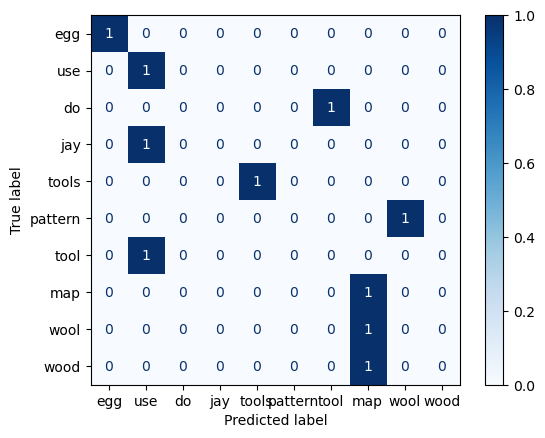

In [185]:
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=labels)

disp.plot(cmap=plt.cm.Blues)
plt.show()

---

# Test Transformer

In [27]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=output_dim
        )
        self.sequence_length = sequence_length
        self.output_dim = output_dim

    def build(self, input_shape):
        self.position_embeddings.build(input_shape)

    def call(self, inputs):
        # The inputs are of shape: `(batch_size, frames, num_features)`
        inputs = keras.ops.cast(inputs, self.compute_dtype)
        length = keras.ops.shape(inputs)[1]
        positions = keras.ops.arange(start=0, stop=length, step=1)
        embedded_positions = self.position_embeddings(positions)
        return inputs + embedded_positions

In [28]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.3
        )
        self.dense_proj = keras.Sequential(
            [
                layers.Dense(dense_dim, activation=keras.activations.gelu),
                layers.Dense(embed_dim),
            ]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

    def call(self, inputs, mask=None):
        attention_output = self.attention(inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

In [44]:
def get_compiled_model(shape):
    sequence_length = MAX_SEQ_LENGTH
    embed_dim = NUM_FEATURES
    dense_dim = 4
    num_heads = 1
    classes = len(label_processor.get_vocabulary())

    inputs = keras.Input(shape=shape)
    x = PositionalEmbedding(
        sequence_length, embed_dim, name="frame_position_embedding"
    )(inputs)
    x = TransformerEncoder(embed_dim, dense_dim, num_heads, name="transformer_layer")(x)
    x = layers.GlobalMaxPooling1D()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(classes, activation="softmax")(x)
    model = keras.Model(inputs, outputs)

    model.compile(
        optimizer="adam",
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model


In [64]:
def get_compiled_model_2(shape):
    sequence_length = MAX_SEQ_LENGTH
    embed_dim = NUM_FEATURES
    dense_dim = 4
    num_heads = 1
    classes = len(label_processor.get_vocabulary())

    inputs = keras.Input(shape=shape)
    x = PositionalEmbedding(
        sequence_length, embed_dim, name="frame_position_embedding"
    )(inputs)
    x = TransformerEncoder(embed_dim, dense_dim, num_heads, name="transformer_layer")(x)
    x = layers.GlobalMaxPooling1D()(x)
    x = layers.Dropout(0.5)(x)
    # x = layers.Dense(400, activation="relu")(x)
    # x = layers.Dense(100, activation="relu")(x)
    outputs = layers.Dense(classes, activation="softmax")(x)
    model = keras.Model(inputs, outputs)

    adam = tf.keras.optimizers.Adam(
        learning_rate=1e-06,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-06,
        amsgrad=False,
        name="Adam",
    )

    model.compile(
        optimizer=adam,
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

In [65]:
def run_experiment(train_data, train_labels, test_data, test_labels):
    filepath = "./video_classifier_241009.weights.h5"
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, save_weights_only=True, save_best_only=True, verbose=1
    )

    model = get_compiled_model_2(train_data.shape[1:])
    history = model.fit(
        train_data,
        train_labels,
        validation_split=0.2,
        epochs=EPOCHS,
        callbacks=[checkpoint],
    )

    model.load_weights(filepath)
    _, accuracy = model.evaluate(test_data, test_labels)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return history, model

In [ ]:
history, trained_model = run_experiment(X_trainval, y_trainval, X_test, y_test)

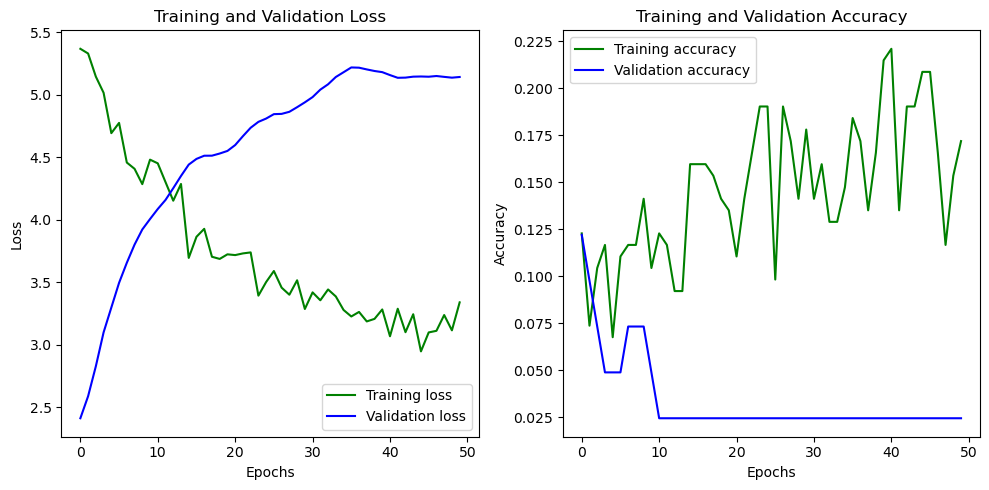

In [63]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plotting loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, 'g', label='Training loss')
plt.plot(val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting accuracy
plt.subplot(1, 2, 2)
plt.plot(train_acc, 'g', label='Training accuracy')
plt.plot(val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

---

# Save Model

In [189]:
model.export(MODEL_DIR + "auslan_words_classifier")

INFO:tensorflow:Assets written to: ../models/auslan_words_classifier/assets


INFO:tensorflow:Assets written to: ../models/auslan_words_classifier/assets


Saved artifact at '../models/auslan_words_classifier'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): List[TensorSpec(shape=(None, 10, 2048), dtype=tf.float32, name='keras_tensor_565'), TensorSpec(shape=(None, 10), dtype=tf.bool, name='keras_tensor_566')]
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  22578792208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  22578790864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  22578793552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  22578792784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  22578793168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  22578790480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  22574200016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  22680612560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  22680612944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  22680610640: TensorSpec(s

In [10]:
# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model(
    TF_MODEL_DIR
)  # path to the SavedModel directory
converter.experimental_enable_resource_variables = True
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,  # Enable TensorFlow Lite ops
    tf.lite.OpsSet.SELECT_TF_OPS,  # Enable TensorFlow ops
]
converter._experimental_lower_tensor_list_ops = False
tflite_model = converter.convert()


# Save the model.
with open(MODEL_DIR + "auslan_word_gru0_classifier_2410202150.tflite", "wb") as f:
    f.write(tflite_model)

W0000 00:00:1729421597.017745 18762213 tf_tfl_flatbuffer_helpers.cc:390] Ignored output_format.
W0000 00:00:1729421597.017755 18762213 tf_tfl_flatbuffer_helpers.cc:393] Ignored drop_control_dependency.
2024-10-20 21:53:17.151753: W tensorflow/compiler/mlir/lite/flatbuffer_export.cc:2996] TFLite interpreter needs to link Flex delegate in order to run the model since it contains the following Select TFop(s):
Flex ops: FlexTensorListReserve, FlexTensorListSetItem, FlexTensorListStack
Details:
	tf.TensorListReserve(tensor<2xi32>, tensor<i32>) -> (tensor<!tf_type.variant<tensor<?x200xf32>>>) : {device = ""}
	tf.TensorListReserve(tensor<2xi32>, tensor<i32>) -> (tensor<!tf_type.variant<tensor<?x400xf32>>>) : {device = ""}
	tf.TensorListSetItem(tensor<!tf_type.variant<tensor<?x200xf32>>>, tensor<i32>, tensor<?x200xf32>) -> (tensor<!tf_type.variant<tensor<?x200xf32>>>) : {device = "", resize_if_index_out_of_bounds = false}
	tf.TensorListSetItem(tensor<!tf_type.variant<tensor<?x400xf32>>>, tenso